# Project Assignment Explainable AI [IT790A], 2025 Fall Term
## Task 2: Global feature importance (SHAP values)

Group 3:

* Lorenz Koch (a24lorko)

* Kim Wurster (a24kimwu)

## Contents

- [Data upload](#Data-upload)

- [Model upload](#Upload-models)

- [Define Y (to predict)](#Define-Y-(to-predict))

- [Split training and test data](#Split-training-and-test-data)

- [Check the parameters of each model](#Check-the-parameters-of-each-model)

- [Performance](#Performance)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
#import pickle

import shap
import time
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost import XGBRegressor

SEED = 0
np.random.seed(SEED)

In [ ]:
def huber_loss(y_true, y_pred, delta=1.0):
    """
    calculate Huber loss
    delta: 1  or 2

    """
    error = y_true - y_pred
    squared_error = 0.5 * (error ** 2)
    absolute_error = delta * (np.abs(error) - 0.5 * delta)
    return np.where(np.abs(error) <= delta, squared_error, absolute_error).mean()

# Data upload

In [ ]:
df = pd.read_csv('../data/day-bikesharing.csv',parse_dates=['dteday'],index_col=1) # Load the data

# Upload models

In [ ]:
totmodel = XGBRegressor()
regmodel = XGBRegressor()
casmodel = XGBRegressor()

totmodel.load_model("./totalmodel_common.json")
regmodel.load_model("./regmodel_common.json")
casmodel.load_model("./casmodel_common.json")

C:\Users\kochl.HIGHEND-GAMING\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1037: UserWarning: [18:33:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:871: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  self.get_booster().load_model(fname)


# Check data

In [ ]:
df.shape

(731, 15)

In [ ]:
def add_features(df):
    df['year'] = df.index.year # yr exists already
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

2011.Jan.1 is a Saturday.

Note: 'dayofweek' 5 means a Saturday.

In [ ]:
add_features(df)
df.head(3)

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year,month,day,dayofweek
dteday,,,,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,2011,1,1,5
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,2011,1,2,6
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,2011,1,3,0


In [ ]:
#This is the normalized version.
# temp: The values are divided to 41 (max)
# atemp: The values are divided to 50 (max)
# hum: The values are divided to 100 (max)
# windspeed: The values are divided to 67 (max)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,731.0,366.000000,211.165812,1.000000,183.500000,366.000000,548.500000,731.000000
season,731.0,2.496580,1.110807,1.000000,2.000000,3.000000,3.000000,4.000000
yr,731.0,0.500684,0.500342,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,731.0,6.519836,3.451913,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,731.0,0.028728,0.167155,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,731.0,2.997264,2.004787,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,731.0,0.683995,0.465233,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,731.0,1.395349,0.544894,1.000000,1.000000,1.000000,2.000000,3.000000
temp,731.0,0.495385,0.183051,0.059130,0.337083,0.498333,0.655417,0.861667
atemp,731.0,0.474354,0.162961,0.079070,0.337842,0.486733,0.608602,0.840896


# Data cleaning

# Categorical variables

Perform one hot encoding on categorical variables. Machine learning algorithms assume (and require) the data to be numeric, so the categorical data must be pre-processed as a numerical data.  Categorical variables turn into binary features that are 'one hot' encoded, so if a feature is represented by that column, it receives a 1, otherwise a 0.

- The 'season' feature has 1: winter, 2: spring, 3: summer, 4: fall.
- The 'holiday' and 'workingday' features are boolean: 1 when it is a holiday. 1 when it is a working day.

In [ ]:
# Define the categorical variables
cat_var = ['season', 'holiday', 'workingday', 'weathersit', 'year']

In [ ]:
# OneHotEncoder
ohe = OneHotEncoder(categories = 'auto')

In [ ]:
# Fit the categorical variables to the encoder
encodeddf = ohe.fit_transform(df[cat_var])

In [ ]:
# Create a DataFrame with the encoded value information
cat_df = pd.DataFrame(data = encodeddf.toarray(), columns = ohe.get_feature_names_out(cat_var))
cat_df

,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,year_2011,year_2012
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
727,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
728,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
729,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
# rename the column names from 1,2,3,4 to spring, summer, fall, winter
cat_df.rename(columns={'season_1': 'winter', 'season_2': 'spring', 'season_3': 'summer', 'season_4': 'fall'}, inplace=True)
cat_df.rename(columns={'weathersit_1': 'clear', 'weathersit_2': 'cloudy', 'weathersit_3': 'lightsnow.rain'}, inplace=True)
cat_df

,winter,spring,summer,fall,holiday_0,holiday_1,workingday_0,workingday_1,clear,cloudy,lightsnow.rain,year_2011,year_2012
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
727,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
728,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
729,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


# Numerical variables

Machine learning is sensitive to the relative scales of numerical variables. The range of all variables need to be normalized so that each feature contributes approximately proportionately to the calculation.

In [ ]:
# Define the numerical variables
num_var = ['temp', 'atemp', 'hum', 'windspeed', 'month', 'day', 'dayofweek']

Create standardized, normalized

In [ ]:
# StandardScaler object
scaler = StandardScaler()

In [ ]:
# Fit the data to the scaler
numscaled = scaler.fit_transform(df[num_var])

Keep the original for later view

In [ ]:
# for inverse transformation
inversed = scaler.inverse_transform(numscaled)
print(inversed)

[[ 0.344167  0.363625  0.805833 ...  1.        1.        5.      ]
 [ 0.363478  0.353739  0.696087 ...  1.        2.        6.      ]
 [ 0.196364  0.189405  0.437273 ...  1.        3.        0.      ]
 ...
 [ 0.253333  0.2424    0.752917 ... 12.       29.        5.      ]
 [ 0.255833  0.2317    0.483333 ... 12.       30.        6.      ]
 [ 0.215833  0.223487  0.5775   ... 12.       31.        0.      ]]


In [ ]:
# Create DataFrame with original data
inversed_df = pd.DataFrame(data = inversed, columns = num_var)
inversed_df

# Calculate based on UCI info to retrieve the actual temperature and weather information
#temp : Normalized temperature in Celsius. The values are divided to 41 (max)
#atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
#hum: Normalized humidity. The values are divided to 100 (max)
#windspeed: Normalized wind speed. The values are divided to 67 (max)
inversed_origin = pd.concat([inversed_df.iloc[:,0] * 41, #temperature
           inversed_df.iloc[:,1] * 50,                   #feeling temperature
           inversed_df.iloc[:,2] * 100,                  #humidity
           inversed_df.iloc[:,3] * 67],                  #wind speed
          axis=1)
inversed_origin

,temp,atemp,hum,windspeed
0,14.110847,18.18125,80.5833,10.749882
1,14.902598,17.68695,69.6087,16.652113
2,8.050924,9.47025,43.7273,16.636703
3,8.200000,10.60610,59.0435,10.739832
4,9.305237,11.46350,43.6957,12.522300
...,...,...,...,...
726,10.420847,11.33210,65.2917,23.458911
727,10.386653,12.75230,59.0000,10.416557
728,10.386653,12.12000,75.2917,8.333661
729,10.489153,11.58500,48.3333,23.500518


Text(0.5, 0, 'daily time (# rows)')

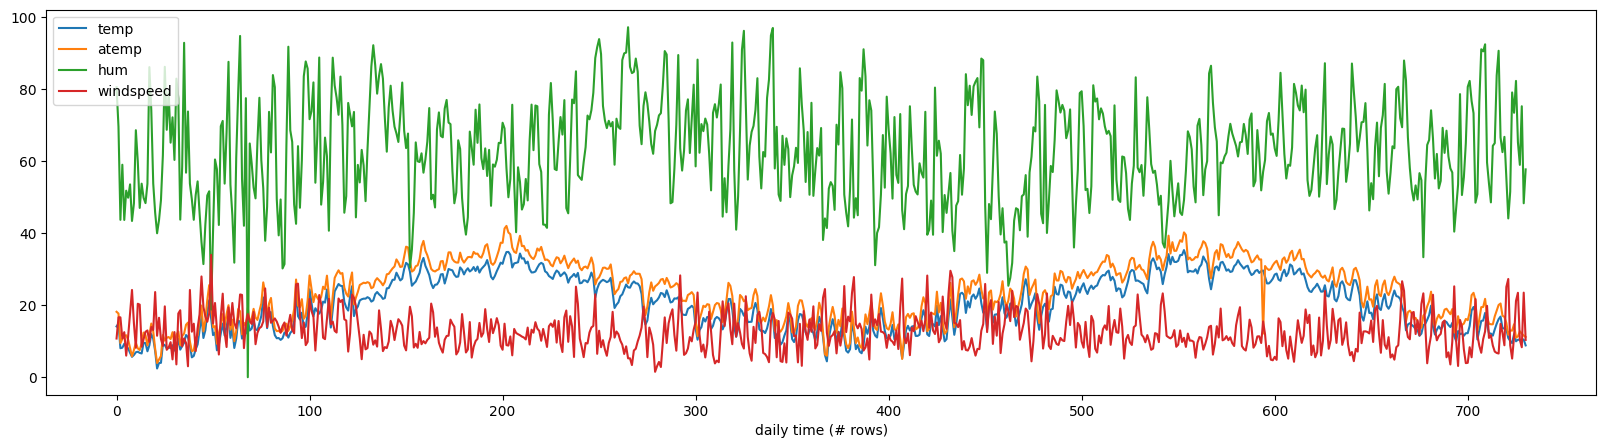

In [ ]:
# timeseries of temp, atemp, humidity, windspeed
ax = inversed_origin.set_index(inversed_origin.index).plot(figsize=(20,5))
ax.set_xlabel('daily time (# rows)')

In [ ]:
X_original = pd.concat([cat_df, inversed_origin, inversed_df[['month', 'day', 'dayofweek']]], axis=1)
X_original # Use this for SHAP plot view

,winter,spring,summer,fall,holiday_0,holiday_1,workingday_0,workingday_1,clear,cloudy,lightsnow.rain,year_2011,year_2012,temp,atemp,hum,windspeed,month,day,dayofweek
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,14.110847,18.18125,80.5833,10.749882,1.0,1.0,5.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,14.902598,17.68695,69.6087,16.652113,1.0,2.0,6.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,8.050924,9.47025,43.7273,16.636703,1.0,3.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,8.200000,10.60610,59.0435,10.739832,1.0,4.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,9.305237,11.46350,43.6957,12.522300,1.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,10.420847,11.33210,65.2917,23.458911,12.0,27.0,3.0
727,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,10.386653,12.75230,59.0000,10.416557,12.0,28.0,4.0
728,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,10.386653,12.12000,75.2917,8.333661,12.0,29.0,5.0
729,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,10.489153,11.58500,48.3333,23.500518,12.0,30.0,6.0


In [ ]:
# Create DataFrame with numerically scaled data
num_df = pd.DataFrame(data = numscaled, columns = num_var)
num_df

,temp,atemp,hum,windspeed,month,day,dayofweek
0,-0.826662,-0.679946,1.250171,-0.387892,-1.600161,-1.674108,0.996930
1,-0.721095,-0.740652,0.479113,0.749602,-1.600161,-1.560522,1.496077
2,-1.634657,-1.749767,-1.339274,0.746632,-1.600161,-1.446936,-1.498809
3,-1.614780,-1.610270,-0.263182,-0.389829,-1.600161,-1.333351,-0.999661
4,-1.467414,-1.504971,-1.341494,-0.046307,-1.600161,-1.219765,-0.500513
...,...,...,...,...,...,...,...
726,-1.318665,-1.521108,0.175807,2.061426,1.588660,1.279122,-0.001366
727,-1.323224,-1.346690,-0.266238,-0.452131,1.588660,1.392707,0.497782
728,-1.323224,-1.424344,0.878392,-0.853552,1.588660,1.506293,0.996930
729,-1.309558,-1.490049,-1.015664,2.069444,1.588660,1.619879,1.496077


Define X (input): Concatenate one hot encoded categorical + normalized numerical data

In [ ]:
Xdf = pd.concat([cat_df, num_df], axis = 1)
print(Xdf.shape)
Xdf.head(5)

(731, 20)


,winter,spring,summer,fall,holiday_0,holiday_1,workingday_0,workingday_1,clear,cloudy,lightsnow.rain,year_2011,year_2012,temp,atemp,hum,windspeed,month,day,dayofweek
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.826662,-0.679946,1.250171,-0.387892,-1.600161,-1.674108,0.996930
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.721095,-0.740652,0.479113,0.749602,-1.600161,-1.560522,1.496077
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,-1.634657,-1.749767,-1.339274,0.746632,-1.600161,-1.446936,-1.498809
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,-1.614780,-1.610270,-0.263182,-0.389829,-1.600161,-1.333351,-0.999661
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,-1.467414,-1.504971,-1.341494,-0.046307,-1.600161,-1.219765,-0.500513


In [ ]:
# Save column names for SHAP usage
NAMES = Xdf.columns
NAMES

Index(['winter', 'spring', 'summer', 'fall', 'holiday_0', 'holiday_1',
       'workingday_0', 'workingday_1', 'clear', 'cloudy', 'lightsnow.rain',
       'year_2011', 'year_2012', 'temp', 'atemp', 'hum', 'windspeed', 'month',
       'day', 'dayofweek'],
      dtype='object')

<Axes: >

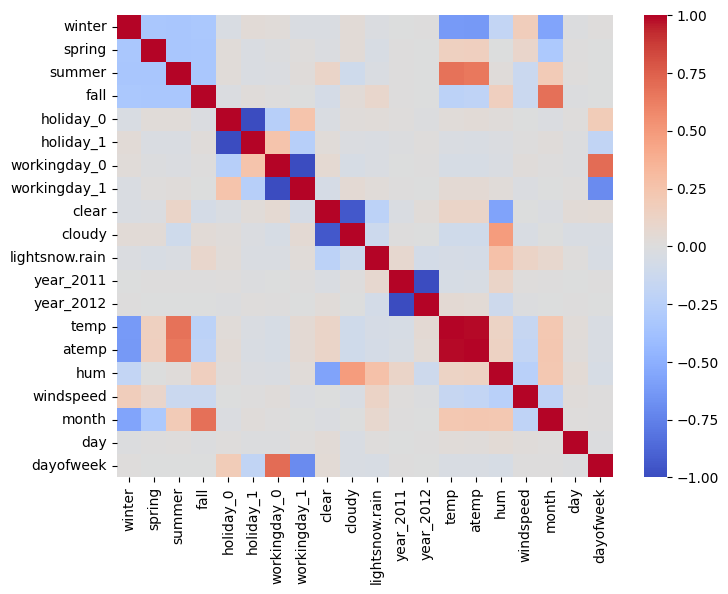

In [ ]:
plt.subplots(figsize=(8, 6))
sb.heatmap(Xdf.corr(), cmap='coolwarm')

In [ ]:
# Check if there is any non available
Xdf.isna().any().sum()

0

# Define Y (to predict)

In [ ]:
# Here, indicate which target to predict (cnt or casual or registered)
y_tot = df['cnt']

# Normalize target data: Calculate mean and standard deviation
y_mu = y_tot.mean(0)
y_sd = y_tot.std(0)

print('y total mean:', y_mu, ' y total std:' , y_sd)

y_tot_norm = (y_tot - y_mu) / y_sd
y_tot_norm = y_tot_norm.values.ravel() #dataframe to 1D array
#y_norm

y total mean: 4504.3488372093025  y total std: 1937.2114516187676


In [ ]:
# Here, indicate which target to predict (cnt or casual or registered)
# For the different models for each customer in the assignment, change the target
y_reg = df['registered']

# Normalize target data: Calculate mean and standard deviation
y_mu = y_reg.mean(0)
y_sd = y_reg.std(0)

print('y registered mean:', y_mu, ' y registered std:' , y_sd)

y_reg_norm = (y_reg - y_mu) / y_sd
y_reg_norm = y_reg_norm.values.ravel() #dataframe to 1D array

y registered mean: 3656.172366621067  y registered std: 1560.2563770194536


In [ ]:
# Here, indicate which target to predict (cnt or casual or registered)
# For the different models for each customer in the assignment, change the target
y_cas = df['casual']

# Normalize target data: Calculate mean and standard deviation
y_mu = y_cas.mean(0)
y_sd = y_cas.std(0)

print('y casual mean:', y_mu, ' y casual std:' , y_sd)

y_cas_norm = (y_cas - y_mu) / y_sd
y_cas_norm = y_cas_norm.values.ravel() #dataframe to 1D array

y casual mean: 848.1764705882352  y casual std: 686.622488284655


In [ ]:
len(y_reg)

731

# Split training and test data

In [ ]:
# Split the data into training, validation, and test data:
X_train_tot, X_test_tot, y_train_tot, y_test_tot = train_test_split(Xdf, y_tot_norm, test_size = 0.2, random_state=SEED)

In [ ]:
# Split the data into training, validation, and test data:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(Xdf, y_reg_norm, test_size = 0.2, random_state=SEED)

In [ ]:
# Split the data into training, validation, and test data:
X_train_cas, X_test_cas, y_train_cas, y_test_cas = train_test_split(Xdf, y_cas_norm, test_size = 0.2, random_state=SEED)

# Check the parameters of each model

In [ ]:
# Check parameters
print(totmodel.get_params())

{'objective': 'reg:pseudohubererror', 'base_score': '5E-1', 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': ['float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float'], 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 's

In [ ]:
# Check parameters
print(regmodel.get_params())

{'objective': 'reg:squarederror', 'base_score': '5E-1', 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': ['float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float'], 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale

In [ ]:
# Check parameters
print(casmodel.get_params())

{'objective': 'reg:pseudohubererror', 'base_score': '5E-1', 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': ['float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float'], 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 's

# Performance

## [Total cnt model] Predict

In [ ]:
y_pred = totmodel.predict(X_test_tot)
r2 = r2_score(y_test_tot, y_pred)

#MAE
test_mae  = mean_absolute_error(y_test_tot, y_pred)

# Huber loss
huber_loss_value = huber_loss(y_test_tot, y_pred, delta=1.0)

print(f"Total count(cnt) model, R2:{r2:.3f}, MAE:{test_mae:.3f}, Huber loss: {huber_loss_value:.3f}")

Total count(cnt) model, R2:0.964, MAE:0.144, Huber loss: 0.020


## [Registered model] Predict

In [ ]:
y_pred = regmodel.predict(X_test_reg)
r2 = r2_score(y_test_reg, y_pred)

#MAE
test_mae  = mean_absolute_error(y_test_reg, y_pred)

# Huber loss
huber_loss_value = huber_loss(y_test_reg, y_pred, delta=1.0)

print(f"Registered model, R2:{r2:.3f}, MAE:{test_mae:.3f}, Huber loss: {huber_loss_value:.3f}")

Registered model, R2:0.971, MAE:0.138, Huber loss: 0.016


## [Casual model] Predict

In [ ]:
y_pred = casmodel.predict(X_test_cas)
r2 = r2_score(y_test_cas, y_pred)

#MAE
test_mae  = mean_absolute_error(y_test_cas, y_pred)

# Huber loss
huber_loss_value = huber_loss(y_test_cas, y_pred, delta=1.0)

print(f"Casual model, R2:{r2:.3f}, MAE:{test_mae:.3f}, Huber loss: {huber_loss_value:.3f}")

Casual model, R2:0.922, MAE:0.181, Huber loss: 0.042


# SHAP Analysis - Feature Importance Comparison

Now we will apply SHAP (SHapley Additive exPlanations) to understand and compare how different features influence predictions across the three models (total, registered, and casual users).

In [ ]:
# Initialize JavaScript for SHAP visualizations
shap.initjs()

# Create SHAP explainers for each model
explainer_tot = shap.TreeExplainer(totmodel)
explainer_reg = shap.TreeExplainer(regmodel)
explainer_cas = shap.TreeExplainer(casmodel)

# Calculate SHAP values for each model using the normalized data
shap_values_tot = explainer_tot.shap_values(Xdf)
shap_values_reg = explainer_reg.shap_values(Xdf)
shap_values_cas = explainer_cas.shap_values(Xdf)


## SHAP Summary Plots Comparison

The summary plots below show the feature importance and impact direction for each model. Features are ordered by importance (top to bottom), with each point representing a sample. The color indicates the feature value (red=high, blue=low) and the x-axis shows the SHAP value (impact on prediction).

C:\Users\kochl.HIGHEND-GAMING\AppData\Local\Temp\ipykernel_31120\4053996936.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_tot, X_original, feature_names=NAMES, show=False)
C:\Users\kochl.HIGHEND-GAMING\AppData\Local\Temp\ipykernel_31120\4053996936.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_reg, X_original, feature_names=NAMES, show=False)
C:\Users\kochl.HIGHEND-GAMING\AppData\Local\Temp\ipykernel_31120\4053996936.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global 

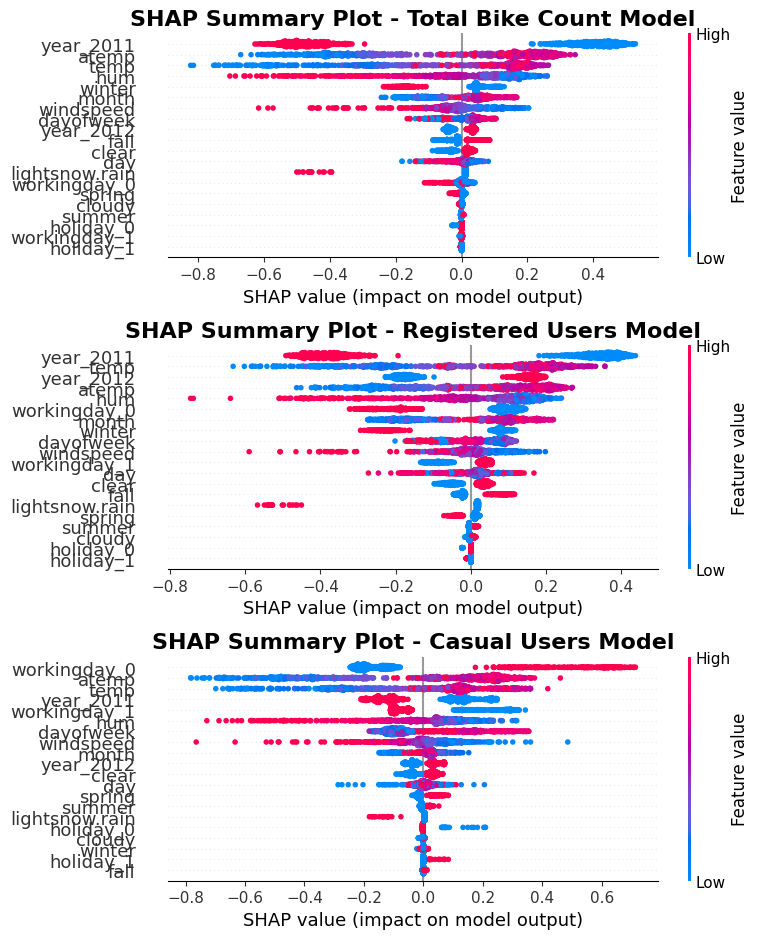

In [ ]:
# Create summary plots for all three models
plt.figure(figsize=(15, 20))

# Total bike count model
plt.subplot(3, 1, 1)
shap.summary_plot(shap_values_tot, X_original, feature_names=NAMES, show=False)
plt.title('SHAP Summary Plot - Total Bike Count Model', fontsize=16, fontweight='bold')

# Registered users model
plt.subplot(3, 1, 2)
shap.summary_plot(shap_values_reg, X_original, feature_names=NAMES, show=False)
plt.title('SHAP Summary Plot - Registered Users Model', fontsize=16, fontweight='bold')

# Casual users model
plt.subplot(3, 1, 3)
shap.summary_plot(shap_values_cas, X_original, feature_names=NAMES, show=False)
plt.title('SHAP Summary Plot - Casual Users Model', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

## Feature Importance Comparison Analysis

### Feature Importance Rankings (Top to Bottom):

**1. Total Bike Count Model (Top plot):**
1. `year_2011` - Most important feature
2. `atemp` (feeling temperature)
3. `temp` (temperature)
4. `hum` (humidity)
5. `winter` (season)
6. `month`
7. `windspeed`
8. `dayofweek`
9. `year_2012`
10. `fall` (season)
11. `clear` (weather)
12. `day`
13. `lightsnow.rain` (weather)

**2. Registered Users Model (Middle plot):**
1. `year_2011` - Dominates feature importance
2. `temp` (temperature)
3. `year_2012`
4. `atemp` (feeling temperature)
5. `hum` (humidity)
6. `workingday_0` (non-working days)
7. `month`
8. `winter` (season)
9. `dayofweek`
10. `windspeed`
11. `workingday_1` (working days)
12. `day`
13. `clear` (weather)

**3. Casual Users Model (Bottom plot):**
1. `workingday_0` (non-working days) - Most important
2. `atemp` (feeling temperature)
3. `temp` (temperature)
4. `year_2011`
5. `workingday_1` (working days)
6. `hum` (humidity)
7. `dayofweek`
8. `windspeed`
9. `year_2012`
10. `clear` (weather)
11. `day`
12. `spring` (season)
13. `summer` (season)



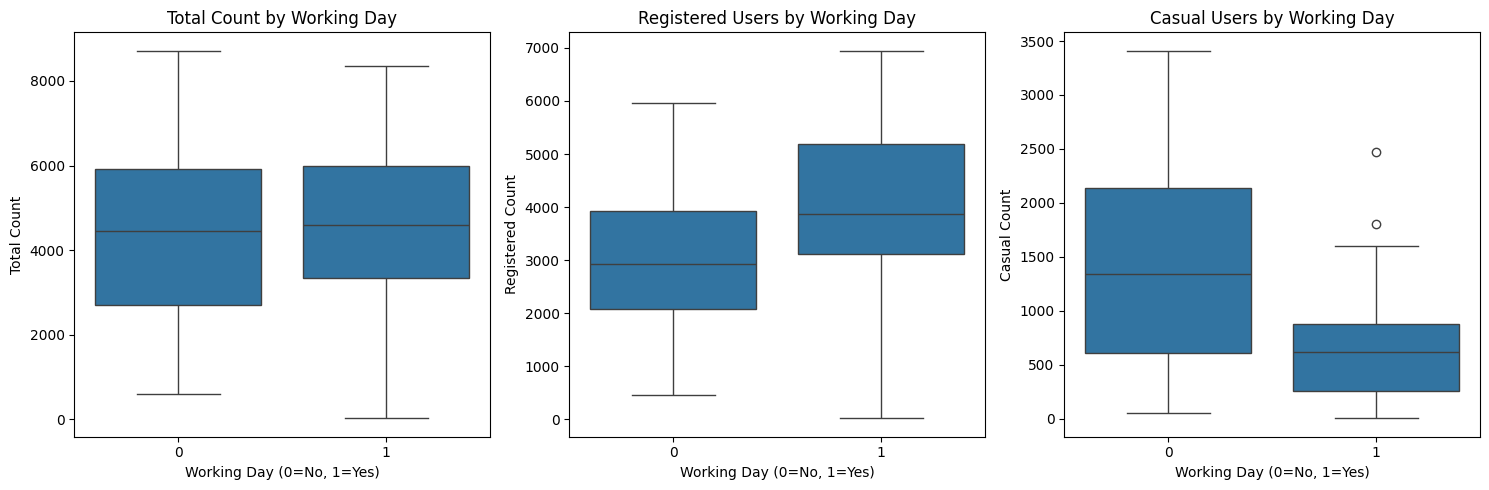

In [ ]:
# Visualize the effect of working day vs non-working day for each customer type
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df is the original dataframe with 'workingday', 'cnt', 'registered', 'casual'
plt.figure(figsize=(15, 5))

# Total count
plt.subplot(1, 3, 1)
sns.boxplot(x=df['workingday'], y=df['cnt'])
plt.title('Total Count by Working Day')
plt.xlabel('Working Day (0=No, 1=Yes)')
plt.ylabel('Total Count')

# Registered users
plt.subplot(1, 3, 2)
sns.boxplot(x=df['workingday'], y=df['registered'])
plt.title('Registered Users by Working Day')
plt.xlabel('Working Day (0=No, 1=Yes)')
plt.ylabel('Registered Count')

# Casual users
plt.subplot(1, 3, 3)
sns.boxplot(x=df['workingday'], y=df['casual'])
plt.title('Casual Users by Working Day')
plt.xlabel('Working Day (0=No, 1=Yes)')
plt.ylabel('Casual Count')

plt.tight_layout()
plt.show()

C:\Users\kochl.HIGHEND-GAMING\AppData\Local\Temp\ipykernel_31120\1502455563.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('hum_bin')['cnt'].mean().plot(marker='o')
C:\Users\kochl.HIGHEND-GAMING\AppData\Local\Temp\ipykernel_31120\1502455563.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('hum_bin')['registered'].mean().plot(marker='o')
C:\Users\kochl.HIGHEND-GAMING\AppData\Local\Temp\ipykernel_31120\1502455563.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavio

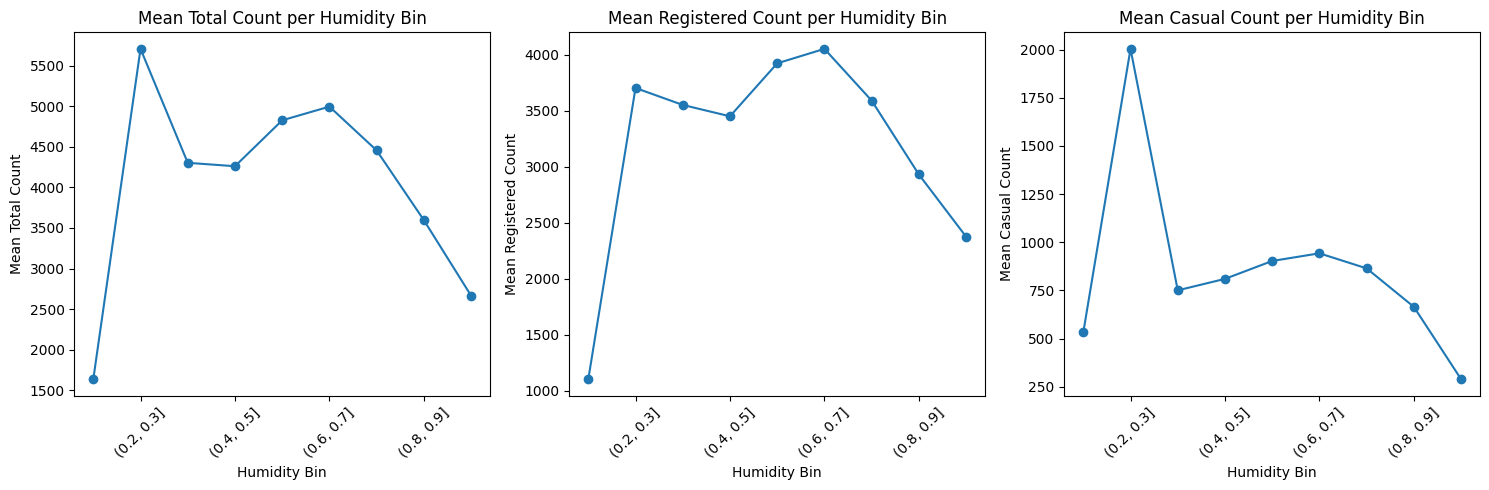

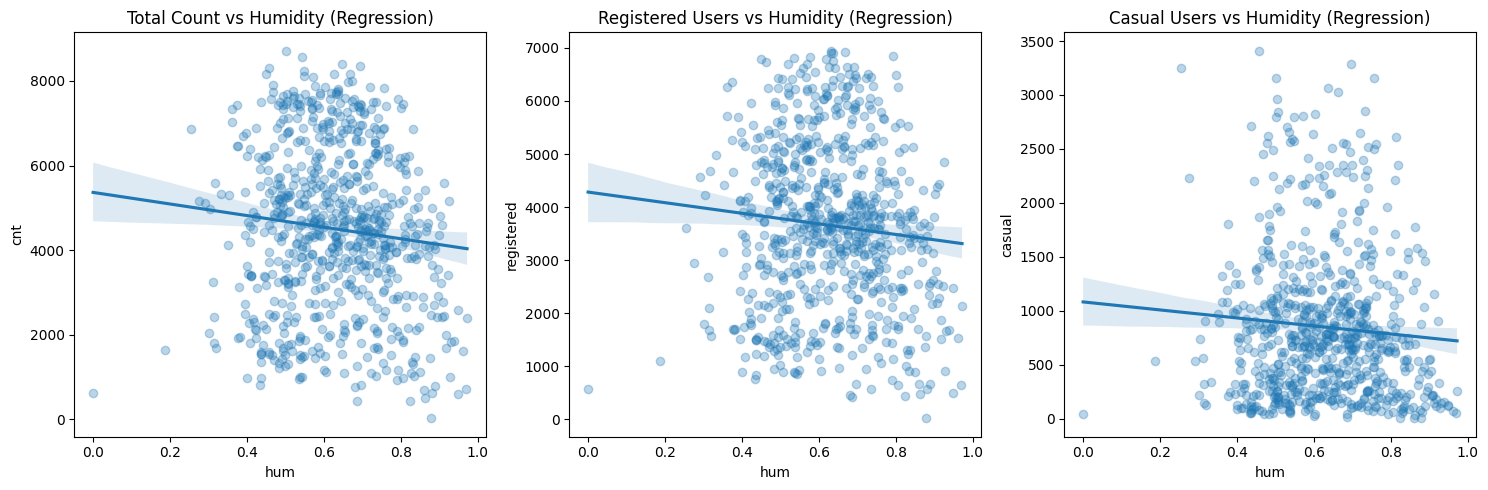

In [ ]:
# Bin humidity into 10 bins and plot mean rental counts per bin
humidity_bins = np.linspace(0, 1, 11)
df['hum_bin'] = pd.cut(df['hum'], bins=humidity_bins)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df.groupby('hum_bin')['cnt'].mean().plot(marker='o')
plt.title('Mean Total Count per Humidity Bin')
plt.xlabel('Humidity Bin')
plt.ylabel('Mean Total Count')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
df.groupby('hum_bin')['registered'].mean().plot(marker='o')
plt.title('Mean Registered Count per Humidity Bin')
plt.xlabel('Humidity Bin')
plt.ylabel('Mean Registered Count')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
df.groupby('hum_bin')['casual'].mean().plot(marker='o')
plt.title('Mean Casual Count per Humidity Bin')
plt.xlabel('Humidity Bin')
plt.ylabel('Mean Casual Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sb.regplot(x='hum', y='cnt', data=df, scatter_kws={'alpha':0.3})
plt.title('Total Count vs Humidity (Regression)')
plt.subplot(1, 3, 2)
sb.regplot(x='hum', y='registered', data=df, scatter_kws={'alpha':0.3})
plt.title('Registered Users vs Humidity (Regression)')
plt.subplot(1, 3, 3)
sb.regplot(x='hum', y='casual', data=df, scatter_kws={'alpha':0.3})
plt.title('Casual Users vs Humidity (Regression)')
plt.tight_layout()
plt.show()

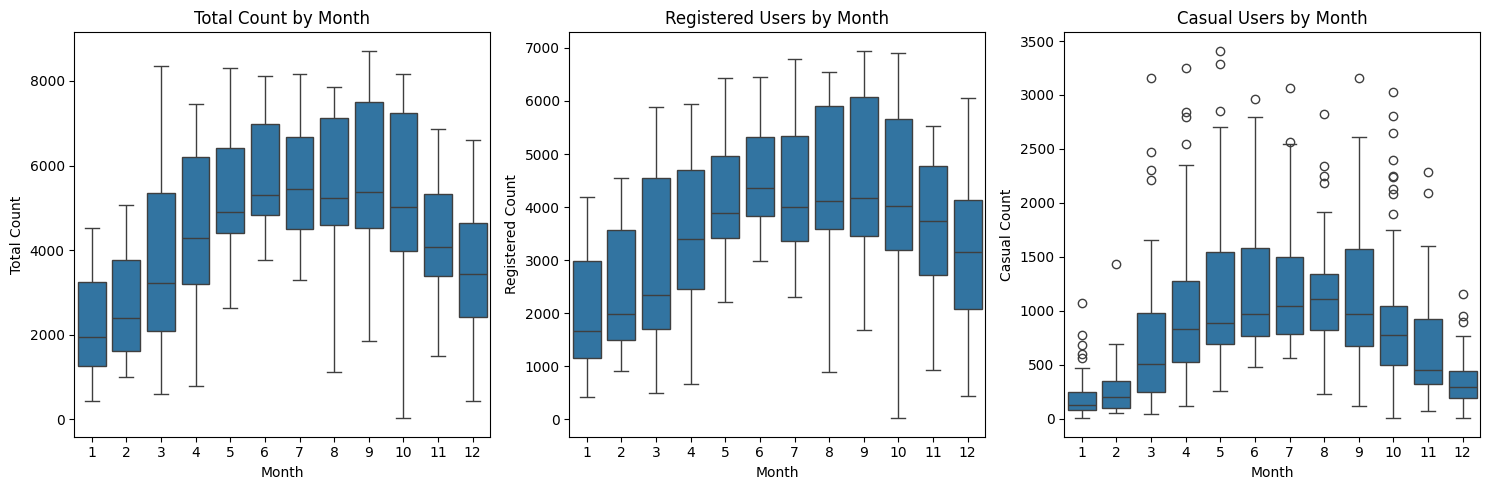

In [ ]:
# Visualize the effect of month on bike rental counts for each customer type
plt.figure(figsize=(15, 5))

# Total count
plt.subplot(1, 3, 1)
sns.boxplot(x=df['month'], y=df['cnt'])
plt.title('Total Count by Month')
plt.xlabel('Month')
plt.ylabel('Total Count')

# Registered users
plt.subplot(1, 3, 2)
sns.boxplot(x=df['month'], y=df['registered'])
plt.title('Registered Users by Month')
plt.xlabel('Month')
plt.ylabel('Registered Count')

# Casual users
plt.subplot(1, 3, 3)
sns.boxplot(x=df['month'], y=df['casual'])
plt.title('Casual Users by Month')
plt.xlabel('Month')
plt.ylabel('Casual Count')

plt.tight_layout()
plt.show()

In [ ]:

# Function to compute median and IQR
def summarize_monthly(df, column):
    summary = df.groupby("month")[column].agg(
        median="median",
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75)
    )
    summary["IQR"] = summary["q3"] - summary["q1"]
    return summary

# Apply to each relevant column
total_summary = summarize_monthly(df, "cnt")
registered_summary = summarize_monthly(df, "registered")
casual_summary = summarize_monthly(df, "casual")

# Display results
print("\n=== Total Count by Month ===")
print(total_summary)

print("\n=== Registered Users by Month ===")
print(registered_summary)

print("\n=== Casual Users by Month ===")
print(casual_summary)



=== Total Count by Month ===
       median       q1       q3      IQR
month                                   
1      1939.0  1251.75  3235.75  1984.00
2      2402.0  1623.00  3777.00  2154.00
3      3216.5  2077.00  5361.00  3284.00
4      4293.5  3188.25  6205.25  3017.00
5      4890.5  4409.00  6405.50  1996.50
6      5308.5  4834.50  6983.00  2148.50
7      5446.5  4491.50  6678.75  2187.25
8      5229.5  4582.50  7121.00  2538.50
9      5384.0  4532.00  7509.25  2977.25
10     5013.0  3967.25  7238.75  3271.50
11     4081.0  3386.00  5317.00  1931.00
12     3444.0  2425.00  4633.00  2208.00

=== Registered Users by Month ===
       median       q1       q3      IQR
month                                   
1      1657.5  1157.75  2986.50  1828.75
2      1977.0  1489.00  3571.00  2082.00
3      2347.0  1699.25  4549.25  2850.00
4      3395.5  2459.50  4692.00  2232.50
5      3883.5  3419.25  4963.50  1544.25
6      4359.0  3827.25  5328.50  1501.25
7      4005.5  3351.75  5332.75  

# SHAP Feature Effect Analysis for Tasks 4–6

In this section, we use SHAP dependence plots to directly visualize how key features—working day, humidity, and month—affect the predictions of each model (total, registered, and casual users). This provides a model-based explanation that complements the descriptive statistics and boxplots above.

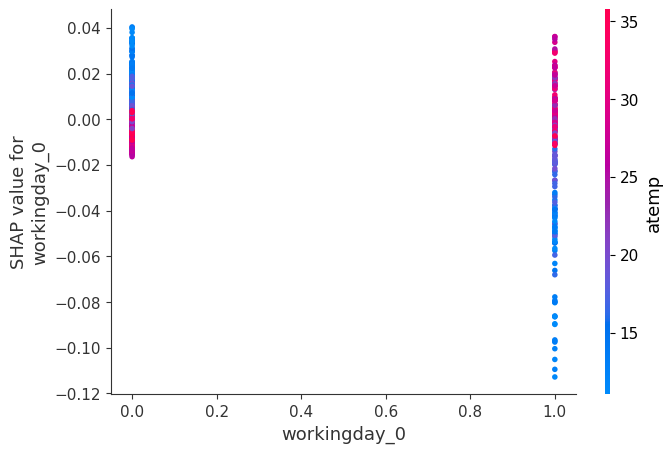

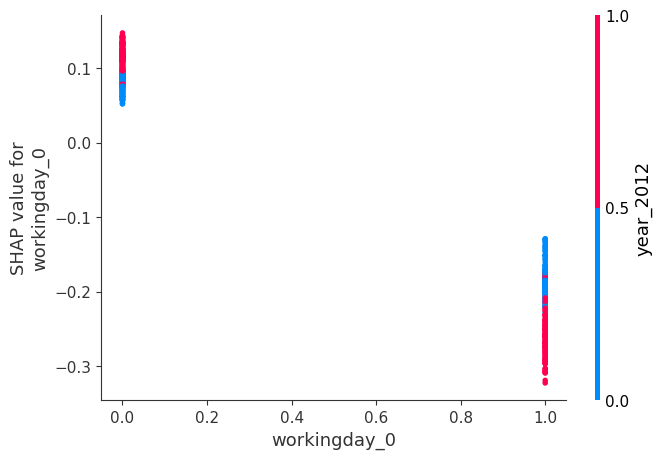

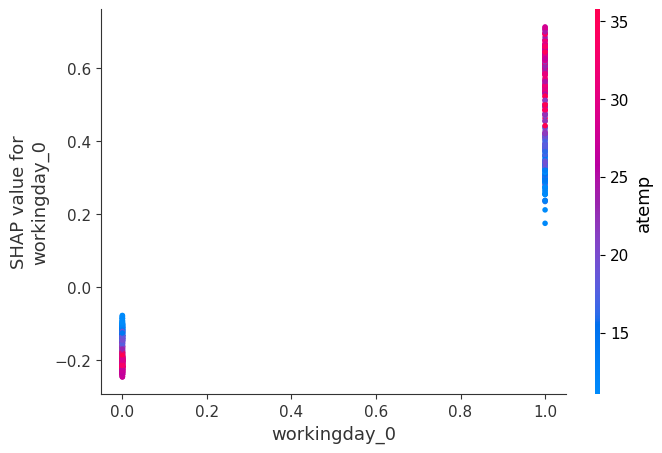

In [ ]:
# SHAP dependence plots for key features
# Task 4: Working Day effect
shap.dependence_plot('workingday_0', shap_values_tot, X_original, show=True)
shap.dependence_plot('workingday_0', shap_values_reg, X_original, show=True)
shap.dependence_plot('workingday_0', shap_values_cas, X_original, show=True)


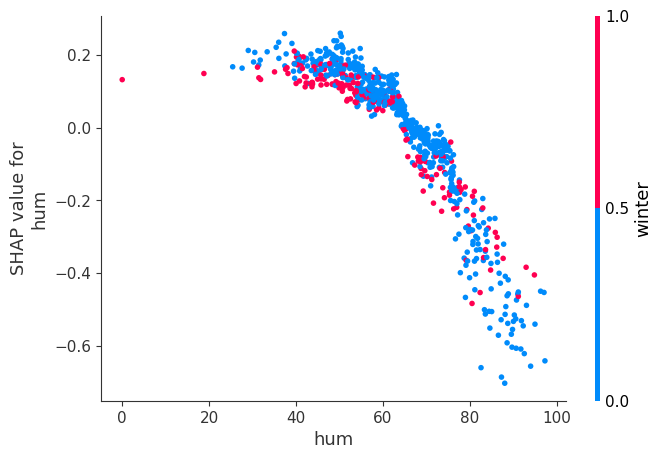

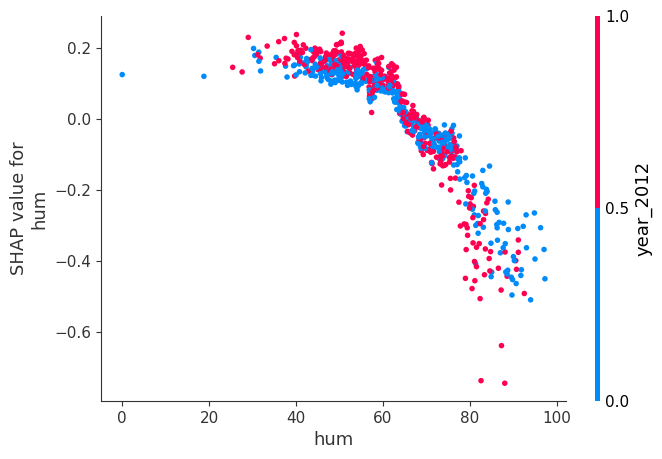

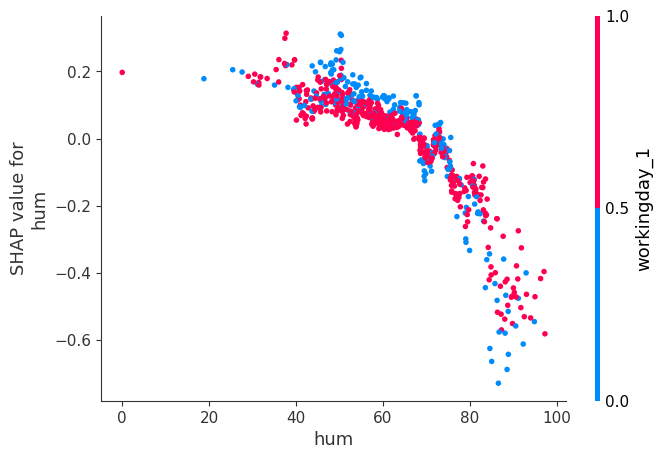

In [ ]:

# Task 5: Humidity effect
shap.dependence_plot('hum', shap_values_tot, X_original, show=True)
shap.dependence_plot('hum', shap_values_reg, X_original, show=True)
shap.dependence_plot('hum', shap_values_cas, X_original, show=True)


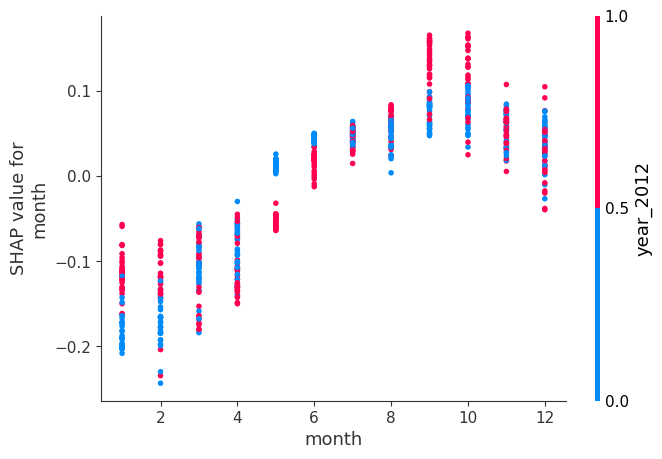

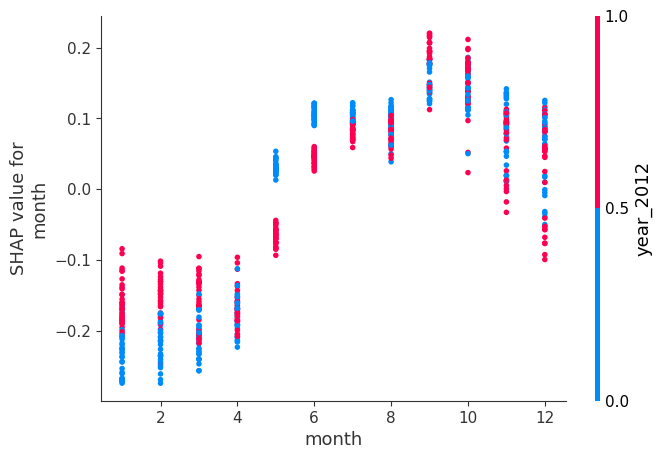

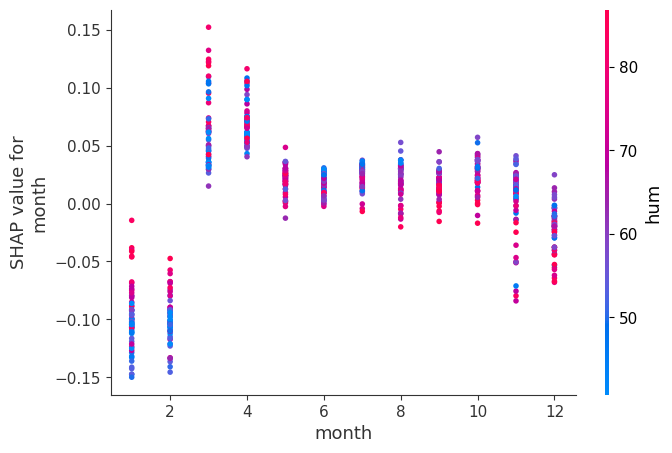

In [ ]:

# Task 6: Month effect
shap.dependence_plot('month', shap_values_tot, X_original, show=True)
shap.dependence_plot('month', shap_values_reg, X_original, show=True)
shap.dependence_plot('month', shap_values_cas, X_original, show=True)

## Task 8: Effect of Wind Speed on Bike Rentals

**Question:**
How does wind speed influence the likelihood to rent a bicycle for each customer type (total, registered, casual), and how do the effects compare? Display related visualizations to support your answer.

Below are visualizations (boxplots, regression plots, and SHAP dependence plots) to support the analysis

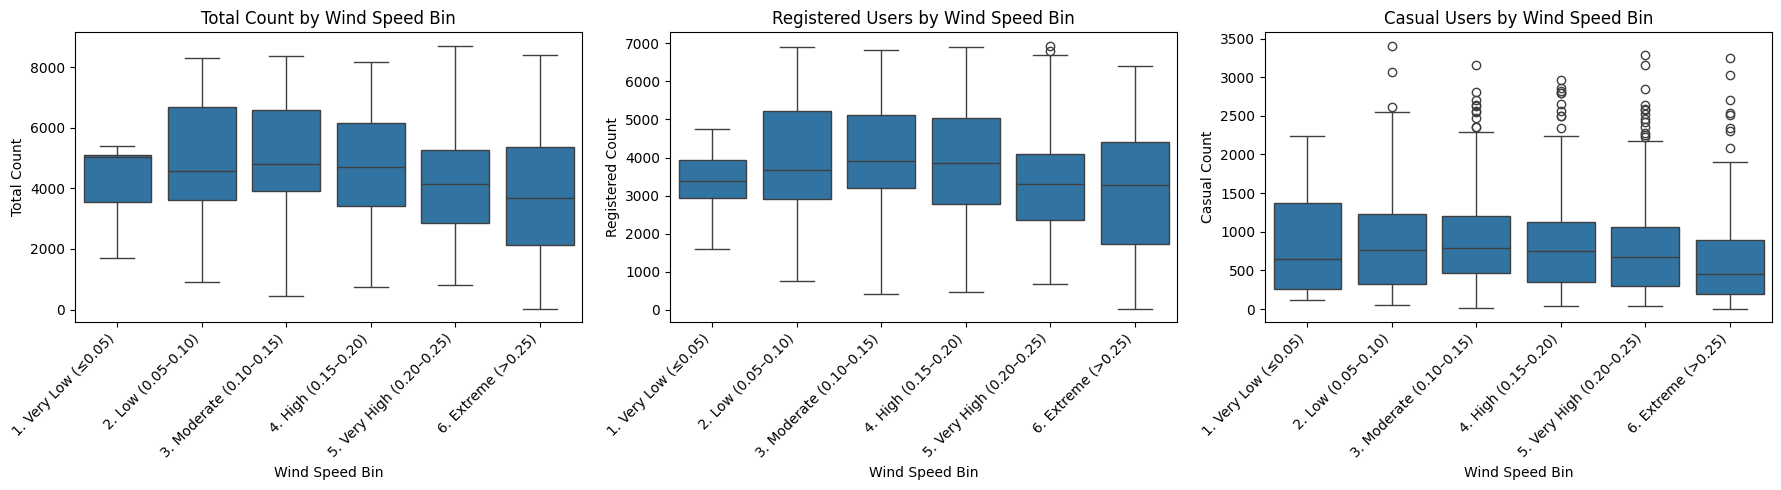

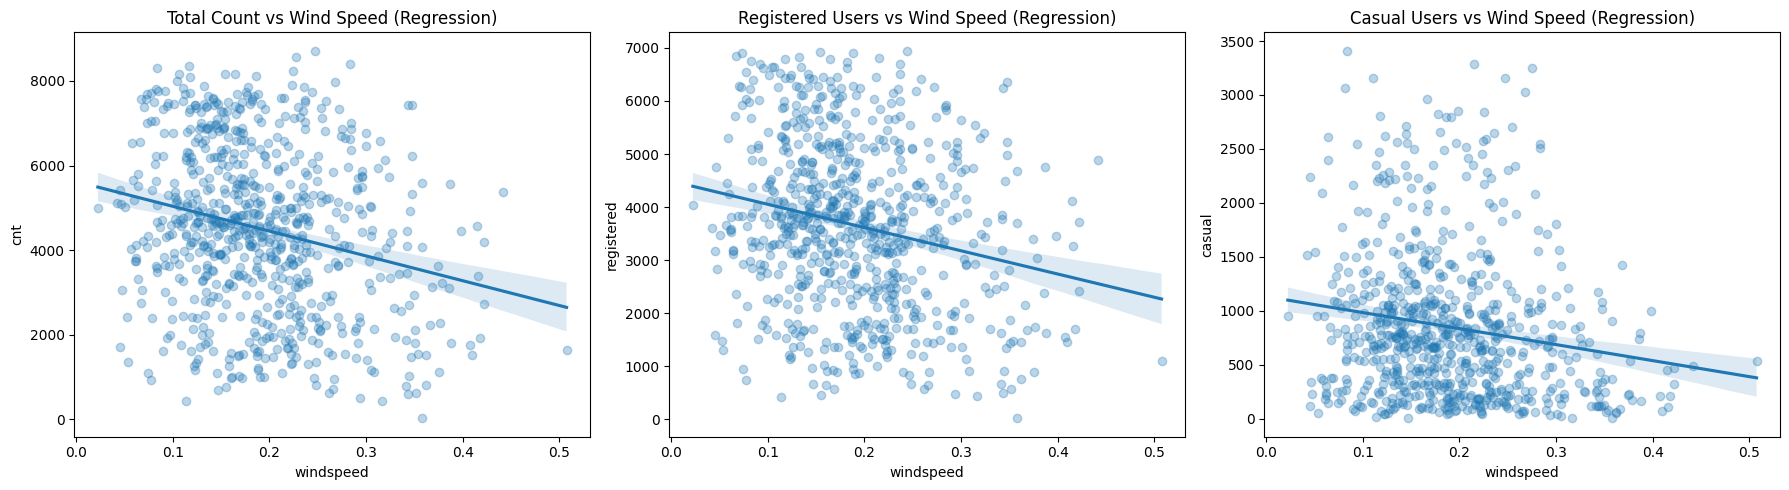

In [ ]:
# Create wind speed bins and readable labels with numbers
wind_bins = [df['windspeed'].min(), 0.05, 0.10, 0.15, 0.20, 0.25, df['windspeed'].max()]
wind_labels = [
    '1. Very Low (≤0.05)',
    '2. Low (0.05–0.10)',
    '3. Moderate (0.10–0.15)',
    '4. High (0.15–0.20)',
    '5. Very High (0.20–0.25)',
    '6. Extreme (>0.25)'
]
df['windspeed_bin'] = pd.cut(df['windspeed'], bins=wind_bins, labels=wind_labels, include_lowest=True)

plt.figure(figsize=(18, 5))

# Boxplots with numbered, readable x-axis labels
plt.subplot(1, 3, 1)
sns.boxplot(x='windspeed_bin', y='cnt', data=df, order=wind_labels)
plt.title('Total Count by Wind Speed Bin')
plt.xlabel('Wind Speed Bin')
plt.ylabel('Total Count')
plt.xticks(rotation=45, ha='right')  # Ensure label end aligns with tick

plt.subplot(1, 3, 2)
sns.boxplot(x='windspeed_bin', y='registered', data=df, order=wind_labels)
plt.title('Registered Users by Wind Speed Bin')
plt.xlabel('Wind Speed Bin')
plt.ylabel('Registered Count')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 3)
sns.boxplot(x='windspeed_bin', y='casual', data=df, order=wind_labels)
plt.title('Casual Users by Wind Speed Bin')
plt.xlabel('Wind Speed Bin')
plt.ylabel('Casual Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Regression plots
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.regplot(x='windspeed', y='cnt', data=df, scatter_kws={'alpha':0.3})
plt.title('Total Count vs Wind Speed (Regression)')
plt.subplot(1, 3, 2)
sns.regplot(x='windspeed', y='registered', data=df, scatter_kws={'alpha':0.3})
plt.title('Registered Users vs Wind Speed (Regression)')
plt.subplot(1, 3, 3)
sns.regplot(x='windspeed', y='casual', data=df, scatter_kws={'alpha':0.3})
plt.title('Casual Users vs Wind Speed (Regression)')
plt.tight_layout()
plt.show()

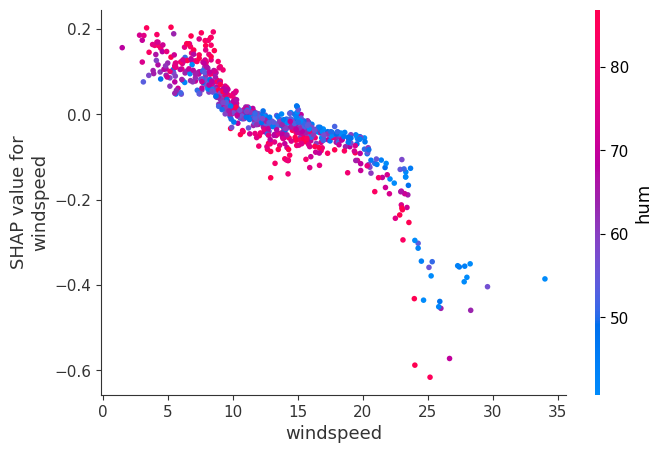

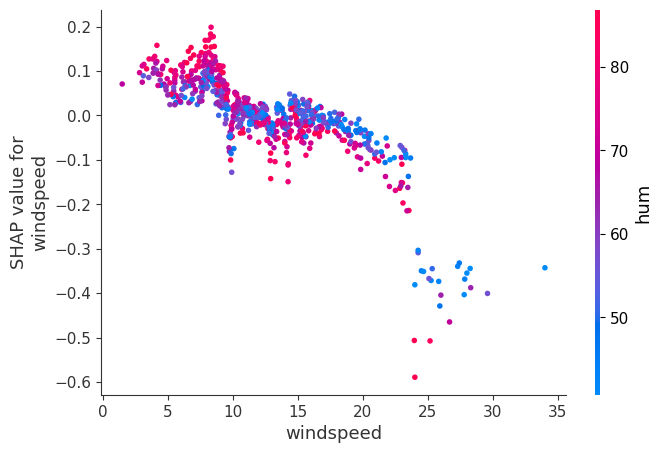

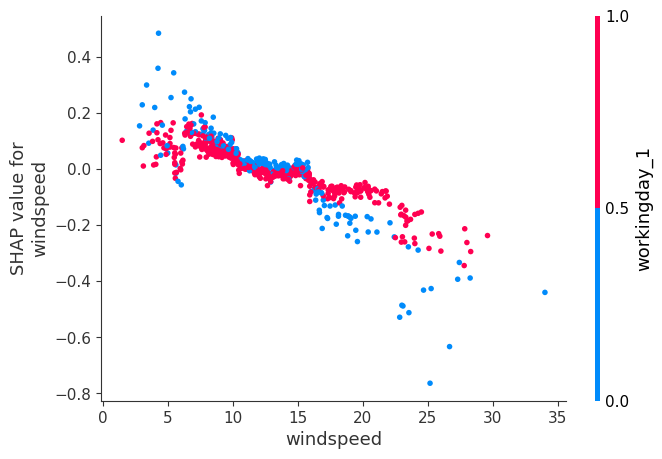

In [ ]:
# SHAP dependence plots for windspeed effect
shap.dependence_plot('windspeed', shap_values_tot, X_original, show=True)
shap.dependence_plot('windspeed', shap_values_reg, X_original, show=True)
shap.dependence_plot('windspeed', shap_values_cas, X_original, show=True)